In [ ]:
!pip install pytorch-lightning
!pip install segmentation-models-pytorch
!pip install rasterio
!pip install tensorboard

# **Imports e Definições**


In [1]:
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import glob
from torch.utils.data import Dataset
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from pytorch_lightning.loggers import TensorBoardLogger


c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive')

## **Função para normalização das bandas para plot.**

In [2]:
def normalize_band(band, stretch_factor=1.5):
  """
  Normalizes a band and stretches contrast.

  Args:
      band: A numpy array representing the band data.
      stretch_factor: A factor to control the amount of contrast stretching (default: 1.5).

  Returns:
      A numpy array with normalized and stretched band values.
  """
  return ((band - band.min()) / (band.max() - band.min()) * stretch_factor)

## **Criação do Dataset com os paths das imagens**

In [3]:
diretorio_base = r'C:/Users/alanb/Documents/'

# Listar arquivos de treino, validação e teste para as imagens de 512x512
train_files_512_nolabel = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/nolabel/train_br/*/*.tif')
val_files_512_nolabel = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/nolabel/val_br/*/*.tif')

# Criar DataFrames e adicionar a coluna 'set_type'
train_df = pd.DataFrame(train_files_512_nolabel, columns=['file_path'])
train_df['set_type'] = 'train'
val_df = pd.DataFrame(val_files_512_nolabel, columns=['file_path'])
val_df['set_type'] = 'val'

# Concatenar todos os DataFrames
df_nolabel = pd.concat([train_df, val_df], ignore_index=True)

# Listar arquivos de treino, validação e teste para as imagens de 512x512
train_files_512_scribble = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/scribble/train_br/*/*.tif')
val_files_512_scribble = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/scribble/val_br/*/*.tif')
test_files_512_scribble = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/scribble/test_br/*/*.tif')

# Criar DataFrames e adicionar a coluna 'set_type'
train_df = pd.DataFrame(train_files_512_scribble, columns=['file_path'])
train_df['set_type'] = 'train'

val_df = pd.DataFrame(val_files_512_scribble, columns=['file_path'])
val_df['set_type'] = 'val'

test_df = pd.DataFrame(test_files_512_scribble, columns=['file_path'])
test_df['set_type'] = 'test'

# Concatenar todos os DataFrames
df_scribble = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Listar arquivos de treino, validação e teste para as imagens de 512x512
train_files_512 = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/high/train_br/*/*.tif')
val_files_512 = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/high/val_br/*/*.tif')
test_files_512 = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p509/high/test_br/*/*.tif')

# Listar arquivos de treino, validação e teste para as imagens de 2048x2048
train_files_2048 = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p2000/train_br/*/*.tif')
val_files_2048 = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p2000/val_br/*/*.tif')
test_files_2048 = glob.glob(diretorio_base + 'CloudSen12_Br_Resized/p2000/test_br/*/*.tif')

# Concatenando os conjuntos de treino, validação e teste
train_files = train_files_512 + train_files_2048
val_files = val_files_512 + val_files_2048
test_files = test_files_512 + test_files_2048

# Criar DataFrames e adicionar a coluna 'set_type'
train_df = pd.DataFrame(train_files, columns=['file_path'])
train_df['set_type'] = 'train'

val_df = pd.DataFrame(val_files, columns=['file_path'])
val_df['set_type'] = 'val'

test_df = pd.DataFrame(test_files, columns=['file_path'])
test_df['set_type'] = 'test'

# Concatenar todos os DataFrames
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

## **Visualização de uma imagem para teste**

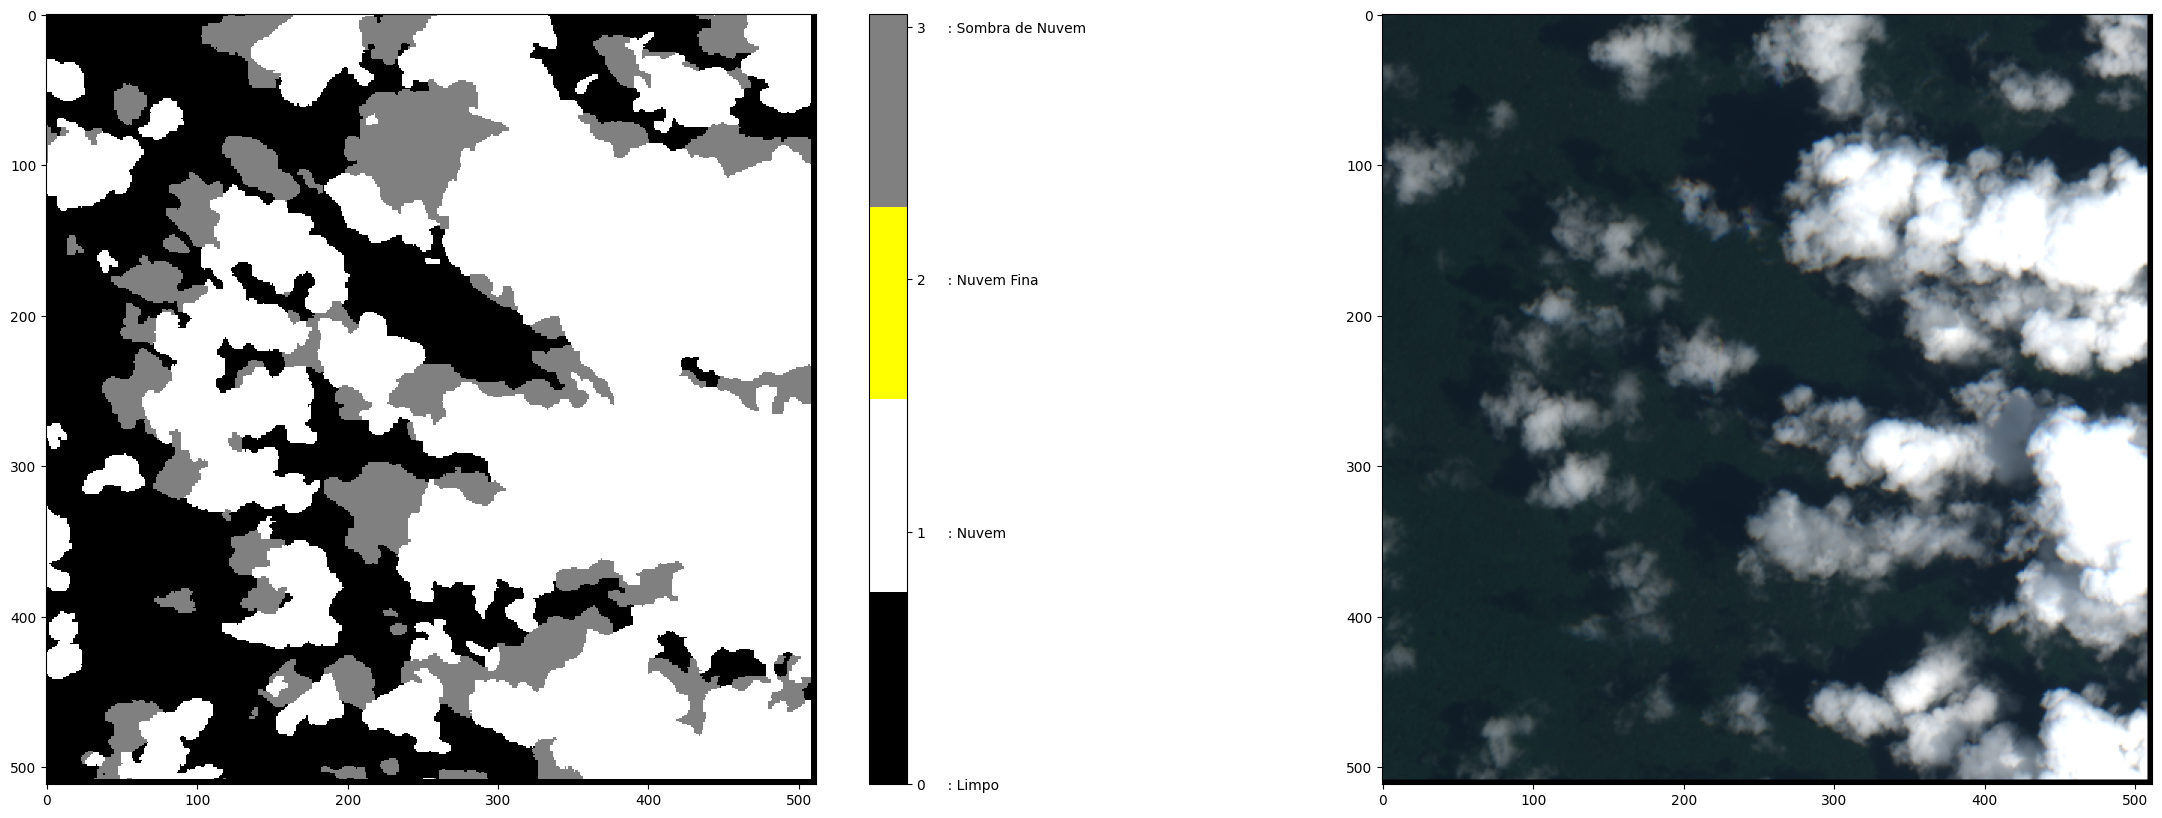

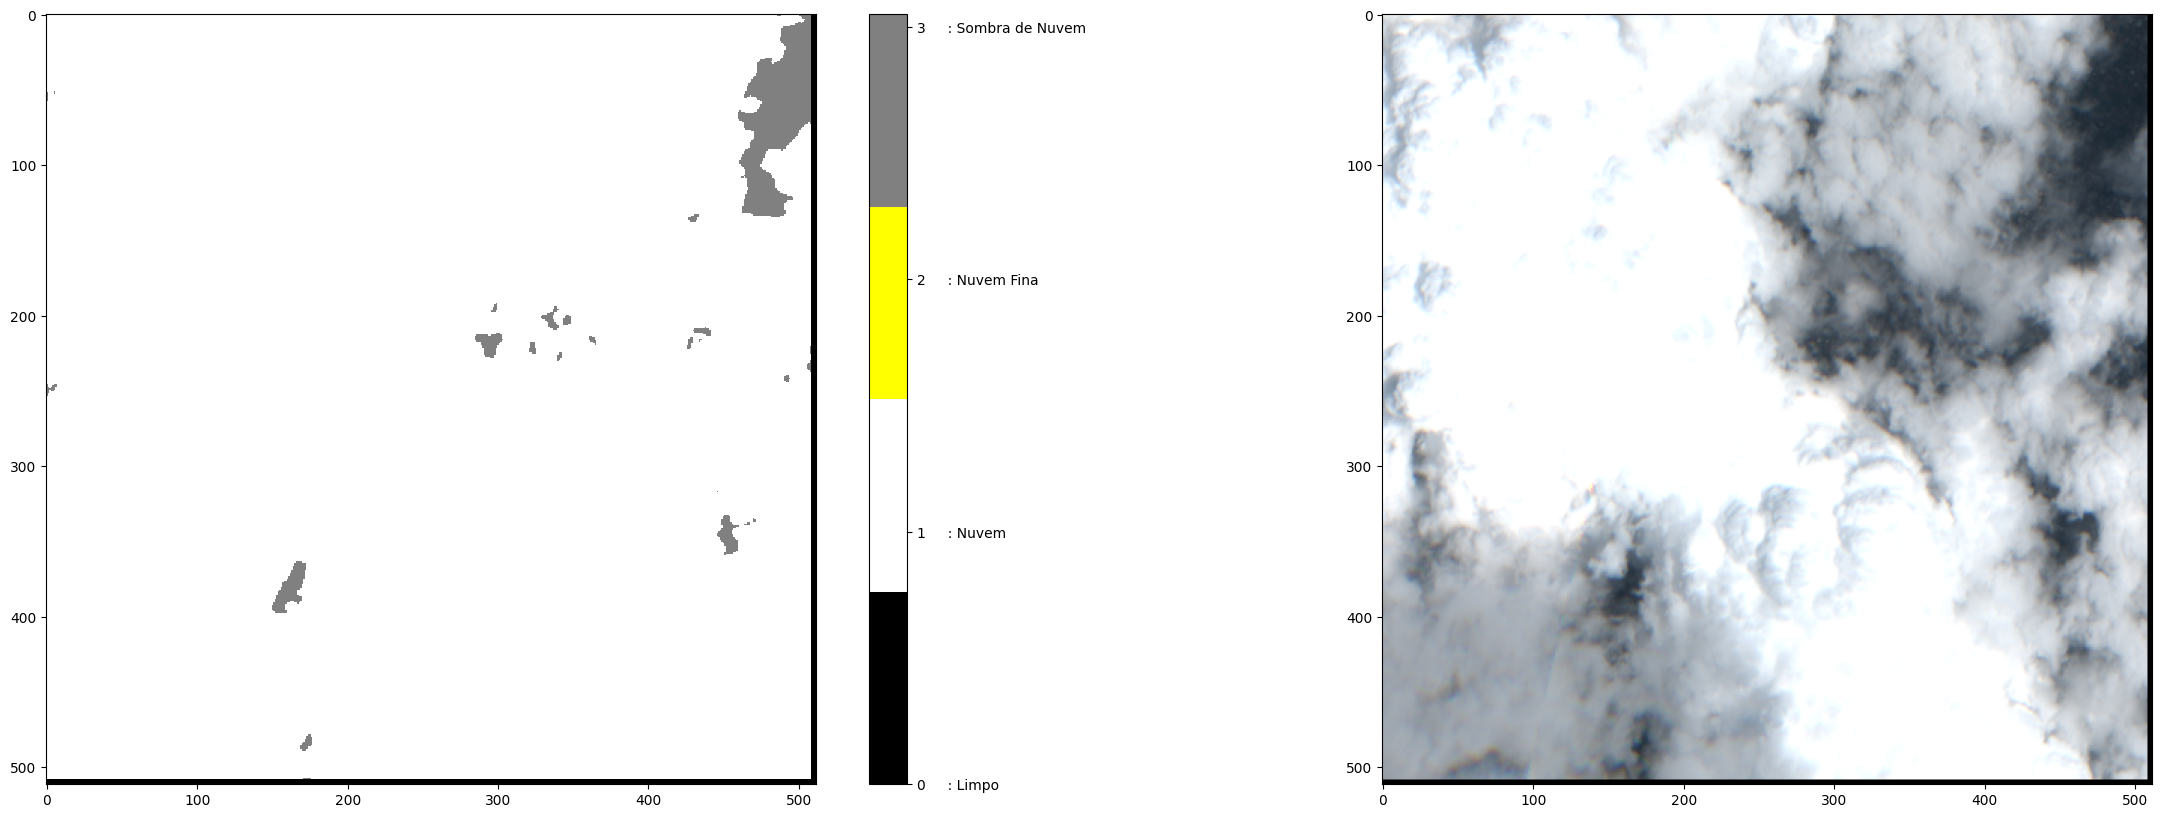

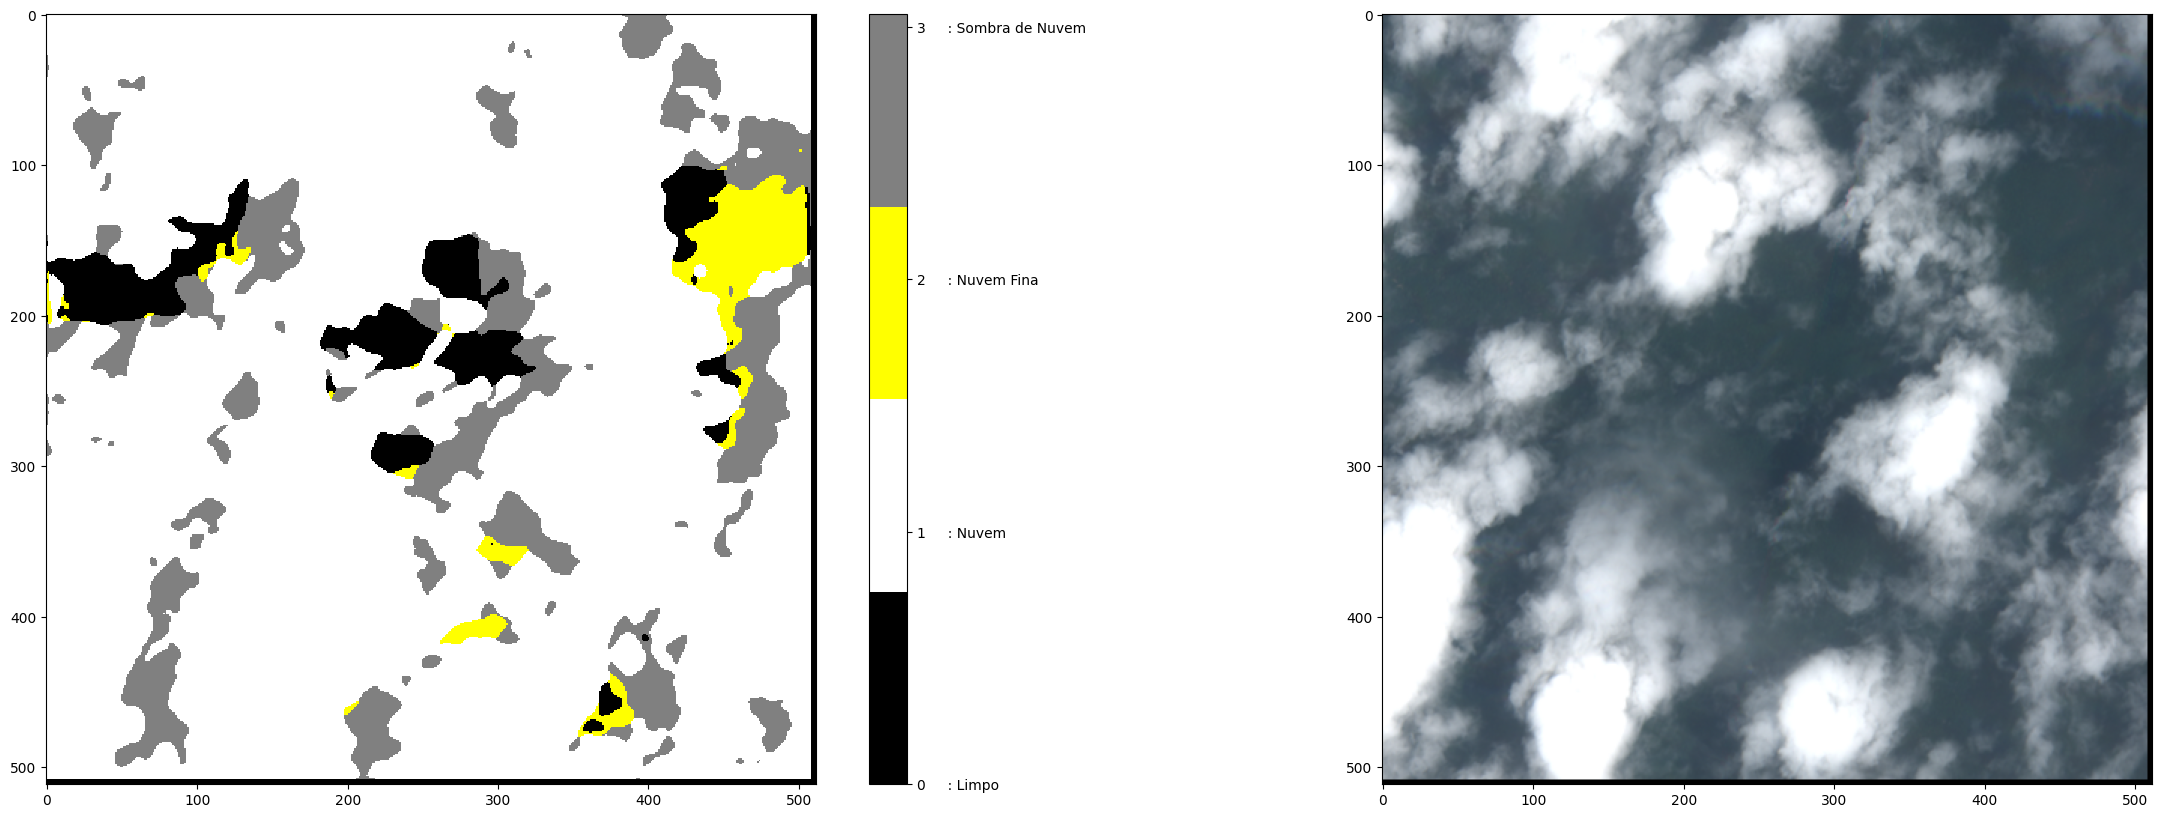

In [4]:

def visualizar_imagem_com_mascara(path:str, index_mask:int=13):
    src = rasterio.open(path)
    # Ler todas as bandas
    sample = src.read()
    b_r = normalize_band(sample[3], stretch_factor=1)
    b_g = normalize_band(sample[2], stretch_factor=1)
    b_b = normalize_band(sample[1], stretch_factor=1)

    rgb_composite_raw = (np.dstack((b_r, b_g, b_b))*1.5).clip(0,1)

    colors = {
        0: 'black',         # Limpo
        1: 'white',         # Nuvem
        2: 'yellow',        # Nuvem Fina
        3: 'gray',          # Sombra de Nuvem
    }

    labels = [
        'Limpo',               # 0
        'Nuvem',               # 1
        'Nuvem Fina',          # 2
        'Sombra de Nuvem'      # 3
    ]

    mascara_de_classificacao = sample[index_mask]

    max_color_len = max(len(color) for color in colors.values())

    # Cria uma lista de cores para a visualização usando Matplotlib
    cmap = ListedColormap([colors[i] for i in colors])

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    im = ax[0].imshow(mascara_de_classificacao, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors)+0.05)
    colorbar = plt.colorbar(im, ax=ax[0], ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {labels[x]}")

    ax[1].imshow(rgb_composite_raw)

#Visualizar imagem do conjunto HIGH
visualizar_imagem_com_mascara(df['file_path'][110])
#Visualizar imagem do conjunto Scribble
visualizar_imagem_com_mascara(df_scribble['file_path'][110], index_mask=14)
#Visualizar imagem do conjunto NoLabel
visualizar_imagem_com_mascara(df_nolabel['file_path'][400], index_mask=14)

# **Data Module (Datasets)**

In [5]:
class CoreDataset(Dataset):
    def __init__(self, subset: pd.DataFrame, index_mask):
        subset.reset_index(drop=True, inplace=True)
        self.subset = subset
        self.index_mask = index_mask

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index: int):
        # Obter o caminho do arquivo a partir do DataFrame
        img_path = self.subset.iloc[index]['file_path']

        #Lê todas as bandas da imagem
        bandas = rasterio.open(img_path).read()

        #Transforma em array numpy
        bandas = np.array(bandas)

        # Assumindo que as bandas estão nos primeiros canais
        X = bandas[0:13, :, :].astype(np.float32) / 10000

        # Assumindo que o alvo está no canal 14 (index 13)
        y = bandas[self.index_mask, :, :].astype(np.int64)

        return X, y


In [6]:
class CoreDataModule(pl.LightningDataModule):
    def __init__(self, dataframe: pd.DataFrame, batch_size: int = 4, train_index_mask: int = 13, val_index_mask: int = 13, test_index_mask: int = 13):
        super().__init__()

        # Separar o DataFrame em datasets de treino, validação e teste
        self.train_dataset = dataframe[dataframe['set_type'] == 'train']
        self.validation_dataset = dataframe[dataframe['set_type'] == 'val']
        self.test_dataset = dataframe[dataframe['set_type'] == 'test']

        # Definir o batch_size
        self.batch_size = batch_size
        self.train_index_mask = train_index_mask
        self.val_index_mask = val_index_mask
        self.test_index_mask = test_index_mask

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.train_dataset, index_mask=self.train_index_mask),
            batch_size=self.batch_size,
            shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.validation_dataset, index_mask=self.val_index_mask),
            batch_size=self.batch_size
           
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            dataset=CoreDataset(self.test_dataset, index_mask=self.test_index_mask),
            batch_size=self.batch_size
            
        )

# **Define o Modelo**

In [7]:
class UNet_S2_Br(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name="mobilenet_v2", encoder_weights=None, classes=4, in_channels=13)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        output = F.softmax(y_hat, dim=1)
        output = torch.argmax(output, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(output, y, mode='multiclass')

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acuracia", accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_iou", iou, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_f1_score", f1_score, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_recall", recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        
        output = F.softmax(y_hat, dim=1)
        output = torch.argmax(output, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(output, y, mode='multiclass')

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_acuracia", accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_iou", iou, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_f1_score", f1_score, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_recall", recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)


        output = F.softmax(y_hat, dim=1)
        output = torch.argmax(output, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(output, y, mode='multiclass')

        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_acuracia", accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_iou", iou, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_f1_score", f1_score, on_step=True, on_epoch=True, prog_bar=True)
        self.log("test_recall", recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# **Define e executa o treinamento das imagens NoLabel**

In [8]:
#dir_root = '/content/drive/MyDrive/Unet'
dir_root = ''

checkpoint_callback = pl.callbacks.ModelCheckpoint(
                                                    dirpath=dir_root,
                                                    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}-trainNoLabel',
                                                    monitor="val_loss",
                                                    mode="min",
                                                    save_top_k=3
                                                  )

earlystopping_callback = pl.callbacks.EarlyStopping(
                                                      monitor="val_loss",
                                                      patience=5,
                                                      mode="min"
                                                    )
# Define the callbacks
callbacks = [checkpoint_callback, earlystopping_callback]

tb_logger = TensorBoardLogger("./lightning_logs", name="UNet_S2_Br")

# Define the trainer
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=callbacks,
    accelerator="auto",
    precision="16-mixed",
    logger=tb_logger,
    default_root_dir=dir_root
)

train_dataloader = torch.utils.data.DataLoader(
                  dataset=CoreDataset(df_nolabel[df_nolabel['set_type'] == 'train'], index_mask=14),
                  batch_size=8
                  
                                              )
val_dataloader = torch.utils.data.DataLoader(
                  dataset=CoreDataset(df_nolabel[df_nolabel['set_type'] == 'val'], index_mask=14),
                  batch_size=8
                  
                                              )

# Define the model
model = UNet_S2_Br()

#Start the training
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

%load_ext tensorboard
%tensorboard --logdir lightning_logs/


c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory  exists and is not empty.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Unet             | 6.6 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.529    Total estimated model params size (MB)
285       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\alanb\anaconda3\envs\cloud\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

## **Recupera o melhor modelo baseado no checkpoint**

In [13]:
# Carregar o melhor modelo diretamente
model = UNet_S2_Br.load_from_checkpoint(checkpoint_callback.best_model_path)

## **Executa um teste com as imagens Scribble**

In [15]:
test_dataloader = torch.utils.data.DataLoader(
                                                dataset=CoreDataset(df_scribble, index_mask=14),
                                                batch_size=8
                                             )


# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=True)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.20809969305992126    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.20809969305992126}]


# **Define e executa o treinamento com as imagens Scribble**

In [16]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
                                                    dirpath='/content/drive/MyDrive/Unet',
                                                    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}-trainScribble',
                                                    monitor="val_loss",
                                                    mode="min",
                                                    save_top_k=3
                                                  )

earlystopping_callback = pl.callbacks.EarlyStopping(
                                            monitor="val_loss",
                                            patience=10,
                                            mode="min"
                                          )
# Define the callbacks
callbacks = [checkpoint_callback, earlystopping_callback]


# Define the trainer
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=callbacks,
    accelerator="auto",
    precision="16-mixed",
    default_root_dir="/content/drive/MyDrive/Unet/"
)

# Define the datamodule
datamodule = CoreDataModule(dataframe=df_scribble, batch_size=4, train_index_mask=14, val_index_mask=14, test_index_mask=14)
#Start the training
trainer.fit(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Unet exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Unet             | 24.5 M | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.873    Total estimated model params size (MB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## **Recupera o melhor modelo baseado no checkpoint**

In [18]:
#Carregar o melhor modelo diretamente
model = UNet_S2_Br.load_from_checkpoint(checkpoint_callback.best_model_path)

## **Executa a validação**

In [20]:
# run val dataset
val_metrics = trainer.validate(model, datamodule=datamodule, verbose=True)
print(val_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.2329980731010437     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2329980731010437}]


## **Executa o teste**

In [21]:
# run test dataset
test_metrics = trainer.test(model, datamodule=datamodule, verbose=True)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17190559208393097    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.17190559208393097}]


## **Execução do teste para cálculo dos métricas parciais**

In [22]:
steps_outputs_metrics = []

for images, gt_masks in datamodule.test_dataloader():
    with torch.no_grad():
        model.eval()
        logits = model.model(images)
    #pr_masks = logits.sigmoid()
    pr_masks = F.softmax(logits, dim=1)
    pr_masks = torch.argmax(pr_masks, dim=1)

    # first compute statistics for true positives, false positives, false negative and
    # true negative "pixels"
    tp, fp, fn, tn = smp.metrics.get_stats(gt_masks, pr_masks, mode='multiclass', num_classes=4)
    steps_outputs_metrics.append({  "tp": tp,
                                    "fp": fp,
                                    "fn": fn,
                                    "tn": tn})

tp = torch.cat([x["tp"] for x in steps_outputs_metrics])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
acuracia_balanceada = smp.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

print(f'Acurácia no conjunto de teste: {acuracia:.4f}')
print(f'Acurácia Balanceada no conjunto de teste: {acuracia_balanceada:.4f}')
print(f'IoU no conjunto de teste: {iou:.4f}')
print(f'F1 no conjunto de teste: {f1_score:.4f}')
print(f'F2 no conjunto de teste: {f2_score:.4f}')
print(f'Recall no conjunto de teste: {recall:.4f}')


Acurácia no conjunto de teste: 0.9696
Acurácia Balanceada no conjunto de teste: 0.9595
IoU no conjunto de teste: 0.8930
F1 no conjunto de teste: 0.9392
F2 no conjunto de teste: 0.9392
Recall no conjunto de teste: 0.9392


# **Define e executa o treinamento com as imagens HIGH**

In [23]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
                                                    dirpath='/content/drive/MyDrive/Unet',
                                                    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}-trainHigh',
                                                    monitor="val_loss",
                                                    mode="min",
                                                    save_top_k=3
                                                  )

earlystopping_callback = pl.callbacks.EarlyStopping(
                                            monitor="val_loss",
                                            patience=10,
                                            mode="min"
                                          )
# Define the callbacks
callbacks = [checkpoint_callback, earlystopping_callback]


# Define the trainer
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=callbacks,
    accelerator="auto",
    precision="16-mixed",
    default_root_dir="/content/drive/MyDrive/Unet/"
)

# Define the datamodule
datamodule = CoreDataModule(dataframe=df, batch_size=4)

#Start the training
trainer.fit(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Unet exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode
--------------------------------------------------
0 | model | Unet             | 24.5 M | eval
1 | loss  | CrossEntropyLoss | 0      | eval
--------------------------------------------------
24.5 M    Trainable params
0         Non-trainable params
24.5 M    Total params
97.873    Total estimated model params size (MB)
0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## **Recupera o melhor modelo baseado no checkpoint**

In [25]:
#Carregar o melhor modelo diretamente
model = UNet_S2_Br.load_from_checkpoint(checkpoint_callback.best_model_path)

## **Executa a validação**

In [27]:
# run val dataset
val_metrics = trainer.validate(model, datamodule=datamodule, verbose=True)
print(val_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.25075414776802063    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.25075414776802063}]


## **Executa o test**

In [28]:
# run test dataset
test_metrics = trainer.test(model, datamodule=datamodule, verbose=True)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5399556159973145     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5399556159973145}]


## **Executa o test para cálculo das métricas finais**

In [29]:
steps_outputs_metrics = []

for images, gt_masks in datamodule.test_dataloader():
    with torch.no_grad():
        model.eval()
        logits = model.model(images)
    #pr_masks = logits.sigmoid()
    pr_masks = F.softmax(logits, dim=1)
    pr_masks = torch.argmax(pr_masks, dim=1)

    # first compute statistics for true positives, false positives, false negative and
    # true negative "pixels"
    tp, fp, fn, tn = smp.metrics.get_stats(gt_masks, pr_masks, mode='multiclass', num_classes=4)
    steps_outputs_metrics.append({  "tp": tp,
                                    "fp": fp,
                                    "fn": fn,
                                    "tn": tn})

tp = torch.cat([x["tp"] for x in steps_outputs_metrics])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
acuracia_balanceada = smp.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

print(f'Acurácia no conjunto de teste: {acuracia:.4f}')
print(f'Acurácia Balanceada no conjunto de teste: {acuracia_balanceada:.4f}')
print(f'IoU no conjunto de teste: {iou:.4f}')
print(f'F1 no conjunto de teste: {f1_score:.4f}')
print(f'F2 no conjunto de teste: {f2_score:.4f}')
print(f'Recall no conjunto de teste: {recall:.4f}')


Acurácia no conjunto de teste: 0.9295
Acurácia Balanceada no conjunto de teste: 0.9061
IoU no conjunto de teste: 0.7797
F1 no conjunto de teste: 0.8591
F2 no conjunto de teste: 0.8591
Recall no conjunto de teste: 0.8591


# **Salva o modelo treinado**

In [30]:
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
smp_model.save_pretrained('/content/drive/MyDrive/Unet/Unet_S2_Br')

## **Carrega o modelo treinado**

In [ ]:
# Define the datamodule
datamodule = CoreDataModule(dataframe=df, batch_size=4)
model = UNet_S2_Br()
# Load the model from the local directory
model.model = smp.from_pretrained('/content/drive/MyDrive/Unet/Unet_S2_Br')

Loading weights from local directory


## **Execução do test para cálculo das métricas**

In [31]:
steps_outputs_metrics = []

for images, gt_masks in datamodule.test_dataloader():
    with torch.no_grad():
        model.eval()
        logits = model.model(images)
    #pr_masks = logits.sigmoid()
    pr_masks = F.softmax(logits, dim=1)
    pr_masks = torch.argmax(pr_masks, dim=1)

    # first compute statistics for true positives, false positives, false negative and
    # true negative "pixels"
    tp, fp, fn, tn = smp.metrics.get_stats(gt_masks, pr_masks, mode='multiclass', num_classes=4)
    steps_outputs_metrics.append({  "tp": tp,
                                    "fp": fp,
                                    "fn": fn,
                                    "tn": tn})

tp = torch.cat([x["tp"] for x in steps_outputs_metrics])
fp = torch.cat([x["fp"] for x in steps_outputs_metrics])
fn = torch.cat([x["fn"] for x in steps_outputs_metrics])
tn = torch.cat([x["tn"] for x in steps_outputs_metrics])

acuracia = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
acuracia_balanceada = smp.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

print(f'Acurácia no conjunto de teste: {acuracia:.4f}')
print(f'Acurácia Balanceada no conjunto de teste: {acuracia_balanceada:.4f}')
print(f'IoU no conjunto de teste: {iou:.4f}')
print(f'F1 no conjunto de teste: {f1_score:.4f}')
print(f'F2 no conjunto de teste: {f2_score:.4f}')
print(f'Recall no conjunto de teste: {recall:.4f}')

Acurácia no conjunto de teste: 0.9295
Acurácia Balanceada no conjunto de teste: 0.9061
IoU no conjunto de teste: 0.7797
F1 no conjunto de teste: 0.8591
F2 no conjunto de teste: 0.8591
Recall no conjunto de teste: 0.8591


## **Visualização das mascáras preditas**

In [44]:
batch = next(iter(datamodule.test_dataloader()))
with torch.no_grad():
    model.eval()
    logits = model.model(batch[0])
#pr_masks = logits.sigmoid()
pr_masks = F.softmax(logits, dim=1)
pr_masks = torch.argmax(pr_masks, dim=1)
#pr_masks = (pr_masks > 0.5).float()
colors = {
    0: 'black',         # Limpo
    1: 'white',         # Nuvem
    2: 'yellow',        # Nuvem Fina
    3: 'gray',          # Sombra de Nuvem
}

labels = [
    'Limpo',                 # 0
    'Nuvem',                 # 1
    'Nuvem Fina',            # 2
    'Sombra de Nuvem'        # 3
]
for idx, (image, gt_mask, pr_mask) in enumerate(zip(batch[0], batch[1], pr_masks)):
    if idx <= datamodule.batch_size-1:
        _, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
        b_r = normalize_band(image[3], stretch_factor=1)
        b_g = normalize_band(image[2], stretch_factor=1)
        b_b = normalize_band(image[1], stretch_factor=1)
        rgb_composite_raw = (np.dstack((b_r, b_g, b_b))*1.5).clip(0,1)
        ax[0].imshow(rgb_composite_raw)
        plt.title("Image")
        plt.axis("off")



        mascara_de_classificacao = gt_mask.numpy().squeeze()

        max_color_len = max(len(color) for color in colors.values())

        # Cria uma lista de cores para a visualização usando Matplotlib
        cmap = ListedColormap([colors[i] for i in colors])


        im = ax[1].imshow(mascara_de_classificacao, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors)+0.05)
        #colorbar = plt.colorbar(im, ax=ax[1], ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {labels[x]}")


        ax[2].imshow(rgb_composite_raw)

        mascara_de_classificacao = pr_mask.numpy().squeeze()

        max_color_len = max(len(color) for color in colors.values())

        # Cria uma lista de cores para a visualização usando Matplotlib
        cmap = ListedColormap([colors[i] for i in colors])


        im = ax[3].imshow(mascara_de_classificacao, cmap=cmap, interpolation='none', vmin=0, vmax=max(colors)+0.05)
        #colorbar = plt.colorbar(im, ax=ax[3], ticks=list(colors.keys()), format=lambda x, pos: f"{x: <{max_color_len}}: {labels[x]}")


    else:
        break

Output hidden; open in https://colab.research.google.com to view.